In [1]:
# %pip install keras-cv

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from keras.models import Model
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2
import keras_cv

In [3]:
#Load tfds dataset
ds, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
test = ds['test']
train = ds['train']
validation = ds['validation']

#Dataset split sizes
train_size = train.cardinality()
print("Test size:", test.cardinality())
print("Train size", train_size)
print("Validation size", validation.cardinality())

Test size: tf.Tensor(6149, shape=(), dtype=int64)
Train size tf.Tensor(1020, shape=(), dtype=int64)
Validation size tf.Tensor(1020, shape=(), dtype=int64)


In [4]:
#Number of flower classes
num_classes = info.features['label'].num_classes
print("Number of flower classes:", num_classes)

Number of flower classes: 102


In [5]:
#Getting the shape of the images. None = varies in size in height and width. Depth = 3 meaning RGB 3 channel image
print(info.features['image'].shape)

(None, None, 3)


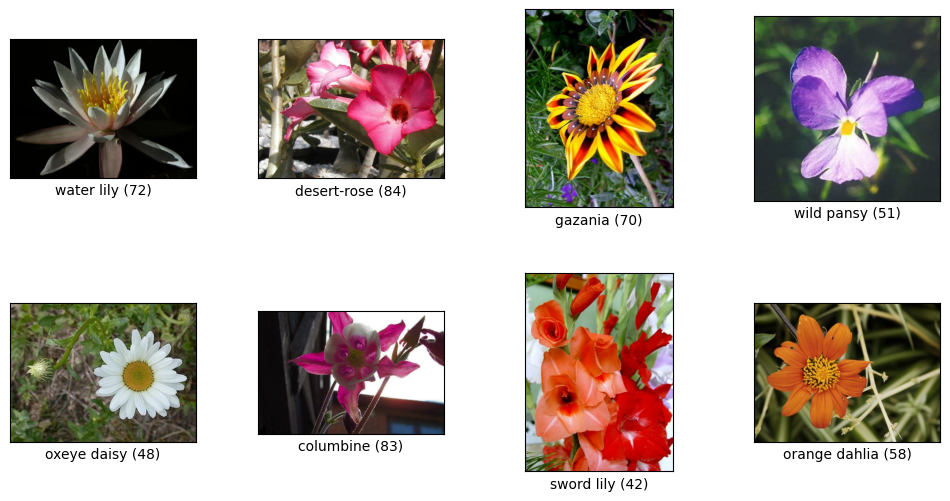

Figure(1200x600)


In [6]:
#Showing some examples of the ds with varying image size and classes
print(tfds.show_examples(train, info, rows=2, cols=4))

In [7]:
batch_size = 32
image_size = 224

def crop_and_resize_image(image, label):
  # label = tf.one_hot(label, num_classes)
  shape = tf.shape(image)
  #[-1] index is the image channel
  height = shape[-3]
  width = shape[-2]

  #takes shortest dimension and crops square
  if height > width:
      image = tf.image.crop_to_bounding_box(image, offset_height=(height - width) // 2, offset_width=0, target_height=width, target_width=width)
  else:
      image = tf.image.crop_to_bounding_box(image, offset_height=0, offset_width=(width - height) // 2, target_height=height, target_width=height)

  # shortest = tf.math.minimum(height, width)
  # image = tf.image.random_crop(image, (shortest, shortest, 3))

  #downsample image
  image = tf.image.resize(image, (image_size, image_size), antialias=False)/255.0
  return image, label

test_batches = test.map(crop_and_resize_image).batch(batch_size)
train_batches = train.cache().map(crop_and_resize_image).shuffle(train_size, reshuffle_each_iteration=False).repeat(5).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_batches = validation.cache().map(crop_and_resize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

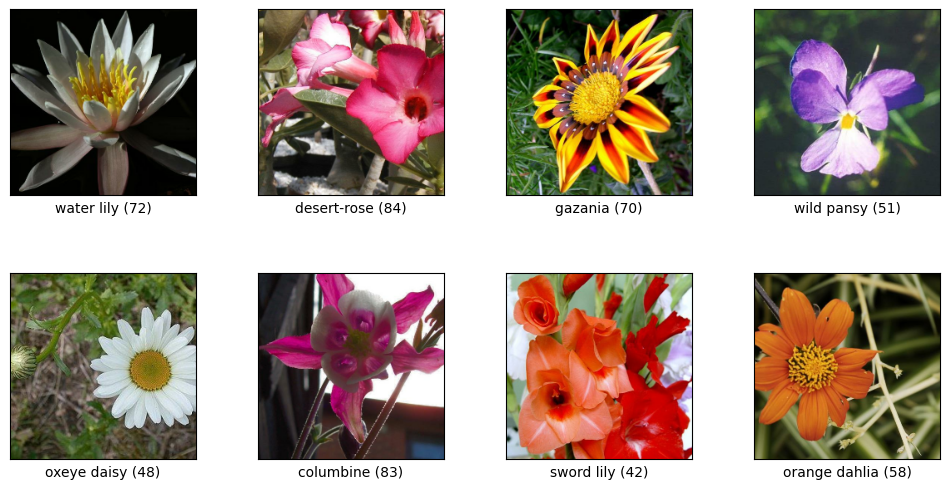

Figure(1200x600)


In [20]:
#Showing some examples of the cropped and resized ds
temp = train.cache().map(crop_and_resize_image)
print(tfds.show_examples(temp, info, rows=2, cols=4))

In [9]:
#Data augmentation
data_augmentation = keras.Sequential([
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.2, value_range=(0, 1)),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
  layers.RandomZoom(0.3, fill_mode='reflect'),
  layers.RandomRotation(0.2)
])

In [10]:
#Defining our model with its layers
model = keras.Sequential([
    # keras_cv.layers.RandAugment(value_range=(0, 1), augmentations_per_image=3, magnitude=0.5, magnitude_stddev=0.15, rate=1),
    data_augmentation,
    layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.0005)),
    layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.0005)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.0005)),
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.0005)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [11]:
# #Resnet model
# def residual(input_layer, n_filters, downsample):
#   input = input_layer
#   if input.shape[-1] != n_filters:
#     input = layers.Conv2D(n_filters, (1,1), strides=(2 if downsample else 1), padding='same', activation='relu', kernel_initializer='he_normal')(input_layer)

#   conv1 = layers.Conv2D(n_filters, (3,3), strides=(2 if downsample else 1), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(input_layer)
#   conv1 = layers.BatchNormalization()(conv1)

#   conv2 = layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(conv1)

#   output_layer = layers.Add()([conv2, input])
#   output_layer = layers.Activation('relu')(output_layer)
#   output_layer = layers.BatchNormalization()(output_layer)
#   return output_layer

# def create_residual_model(initial_filters, block_set):
#   input_layer = layers.Input(shape=(image_size, image_size, 3))
#   n_filters = initial_filters

#   x = input_layer
#   x = data_augmentation(x)
#   x = layers.Conv2D(64, (7, 7), strides=2)(x)
#   x = layers.MaxPooling2D((3, 3), strides=2)(x)
#   for i in range(len(block_set)):
#     num_blocks = block_set[i]
#     for j in range(num_blocks):
#       x = residual(x, n_filters, j==0 and i!=0)
#     n_filters = n_filters * 2

#   x = layers.AveragePooling2D()(x)
#   x = layers.Flatten()(x)
#   x = layers.Dense(num_classes, activation='softmax')(x)
#   residual_model = Model(inputs=input_layer, outputs=x)
#   return residual_model


# model = create_residual_model(64, [2, 2, 2, 2])
# # model = keras.Sequential([
# #     data_augmentation,
# #     create_residual_model(64, [2, 2, 2, 2]),
# #     layers.GlobalAveragePooling2D(),
# #     layers.Flatten(),
# #     layers.Dropout(0.5),
# #     layers.Dense(num_classes, activation='softmax')
# # ])

In [12]:
#Compiles our model
model.compile(
  # optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
  loss=keras.losses.SparseCategoricalCrossentropy(), #Sparse means labels can be integers rather than one-hot enocded
  metrics=['accuracy']
  )

In [13]:
#Adding callbacks
callbacks = [
    #keras.callbacks.ModelCheckpoint(filepath='checkpoint.h5', save_best_only=True, monitor='val_loss'),
    #keras.callbacks.EarlyStopping(patience=5)
]

In [14]:
#Train model and store results
num_epochs = 50
train_history = model.fit(x=train_batches, epochs=num_epochs, callbacks=callbacks, validation_data=validation_batches)

Epoch 1/50
160/160 [==============================] - 40s 174ms/step - loss: 4.4952 - accuracy: 0.0271 - val_loss: 4.0466 - val_accuracy: 0.0833
Epoch 2/50
160/160 [==============================] - 24s 145ms/step - loss: 4.0207 - accuracy: 0.0680 - val_loss: 3.6664 - val_accuracy: 0.1353
Epoch 3/50
160/160 [==============================] - 25s 148ms/step - loss: 3.7207 - accuracy: 0.1027 - val_loss: 3.4306 - val_accuracy: 0.2000
Epoch 4/50
160/160 [==============================] - 26s 156ms/step - loss: 3.5119 - accuracy: 0.1453 - val_loss: 3.2553 - val_accuracy: 0.2422
Epoch 5/50
160/160 [==============================] - 25s 149ms/step - loss: 3.3278 - accuracy: 0.1757 - val_loss: 3.1387 - val_accuracy: 0.2627
Epoch 6/50
160/160 [==============================] - 25s 150ms/step - loss: 3.1469 - accuracy: 0.2114 - val_loss: 3.1318 - val_accuracy: 0.2461
Epoch 7/50
160/160 [==============================] - 25s 152ms/step - loss: 2.9916 - accuracy: 0.2437 - val_loss: 2.9903 - val_ac

In [15]:
model.evaluate(test_batches)

193/193 [==============================] - 15s 78ms/step - loss: 3.1120 - accuracy: 0.4256


[3.111968755722046, 0.4255976676940918]

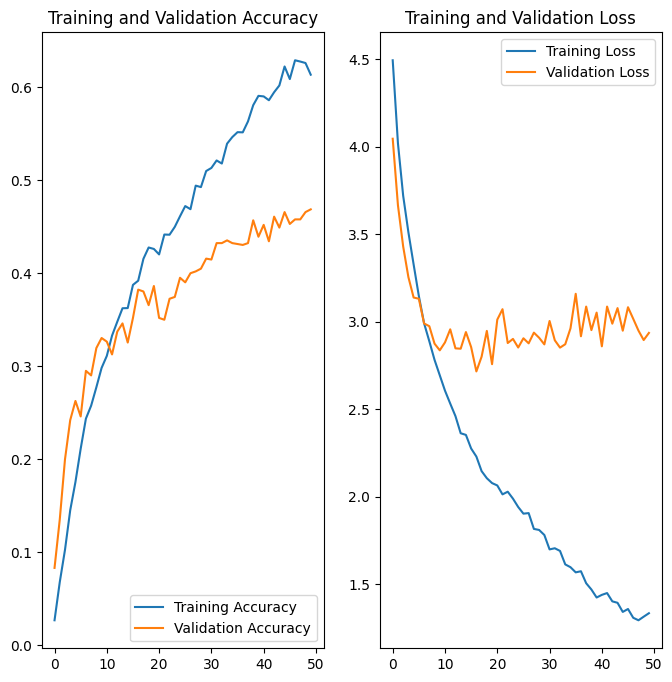

In [16]:
# Creating plots of the loss of accuracy on the training and validation sets
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(num_epochs)

# Training and Validation Accuracy
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

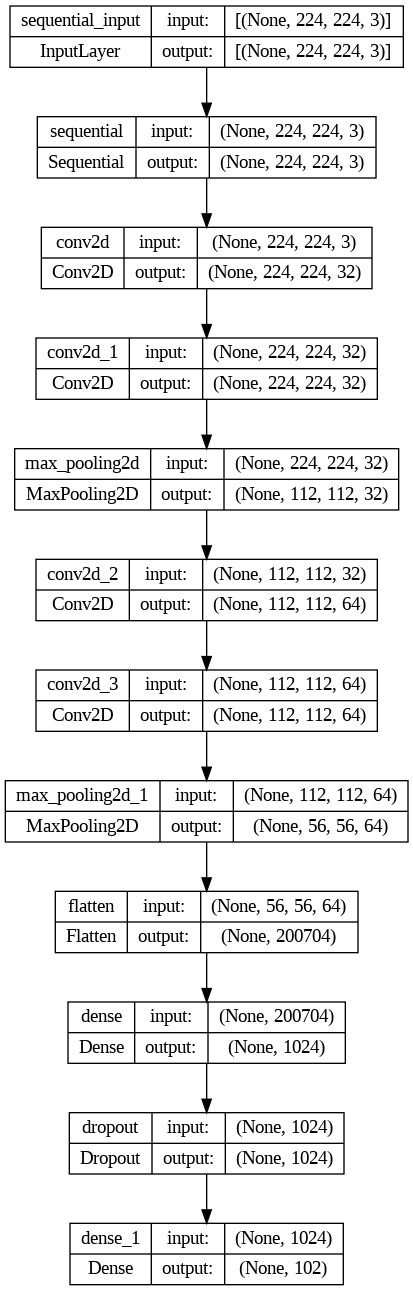

In [17]:
plot_model(model, show_shapes=True, to_file='residual_module.png')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                      